In [1]:
import pandas as pd
import numpy as np
from copy import deepcopy 
from matplotlib import pyplot as plt
import warnings

warnings.filterwarnings('ignore')
np.set_printoptions(suppress = True)

# Trainng Samples loaded from Github Repo
ratings_path = 'https://raw.githubusercontent.com/usef-kh/EC503Project/master/Datasets/ml-1m/ratings.dat'
titles_path = 'https://raw.githubusercontent.com/usef-kh/EC503Project/master/Datasets/ml-1m/movies.dat'

ratings = pd.read_csv(ratings_path, sep  = "::", names = ['UserID', 'MovieID', 'Rating', 'Timestamp'])
titles = pd.read_csv(titles_path, sep = "::", names = ['MovieID', 'Title', 'Genres'], encoding ='latin-1')
data = pd.merge(ratings, titles, on='MovieID')

ntotal = data.shape[0]
ntrain = int(np.floor(ntotal*0.85))
ntest = ntotal - ntrain

print(f"ntotal: {ntotal}\nntrain: {ntrain}\nntest: {ntest}")

data.head()

ntotal: 1000209
ntrain: 850177
ntest: 150032


,UserID,MovieID,Rating,Timestamp,Title,Genres
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest (1975),Drama
1,2,1193,5,978298413,One Flew Over the Cuckoo's Nest (1975),Drama
2,12,1193,4,978220179,One Flew Over the Cuckoo's Nest (1975),Drama
3,15,1193,4,978199279,One Flew Over the Cuckoo's Nest (1975),Drama
4,17,1193,5,978158471,One Flew Over the Cuckoo's Nest (1975),Drama


In [2]:
np.random.seed(42)
shuffled_data = data.reindex(np.random.permutation(data.index))

train = deepcopy(shuffled_data)
test = deepcopy(shuffled_data)

train['Rating'][ntrain:] = -1
test['Rating'][:ntrain] = -1

train_mtx = train.pivot_table(index='UserID', columns='Title', values='Rating')
test_mtx = test.pivot_table(index='UserID', columns='Title', values='Rating')

train_mtx = train_mtx.values
test_mtx = test_mtx.values

train_mtx[train_mtx == -1] = np.nan
test_mtx[test_mtx == -1] = np.nan

train_select = ~(np.isnan(train_mtx))
test_select = ~(np.isnan(test_mtx))

movie_means = np.round(2 * np.nanmean(train_mtx, axis = 1))/2
inds = np.where(np.isnan(train_mtx))
train_mtx[inds] = np.take(movie_means, inds[1])

print(np.shape(test_mtx), np.shape(train_mtx))
print(np.shape(test_select), np.shape(train_select))

train.head()

(6040, 3706) (6040, 3706)
(6040, 3706) (6040, 3706)


,UserID,MovieID,Rating,Timestamp,Title,Genres
895536,5755,184,3,958280246,Nadja (1994),Drama
899739,4585,519,3,964321944,Robocop 3 (1993),Sci-Fi|Thriller
55687,1503,3114,4,974762175,Toy Story 2 (1999),Animation|Children's|Comedy
63727,2166,648,4,974614593,Mission: Impossible (1996),Action|Adventure|Mystery
822011,3201,2178,5,968626301,Frenzy (1972),Thriller


In [3]:
test['Rating'][:ntrain] = np.nan
test.dropna(inplace = True)
test.head()

,UserID,MovieID,Rating,Timestamp,Title,Genres
750152,3821,1218,4.0,975104845,"Killer, The (Die xue shuang xiong) (1989)",Action|Thriller
336085,4080,3682,3.0,965442548,Magnum Force (1973),Western
845212,4277,2155,5.0,965645457,"Slums of Beverly Hills, The (1998)",Comedy
194076,438,653,4.0,976250166,Dragonheart (1996),Action|Adventure|Fantasy
343179,4186,912,3.0,965328471,Casablanca (1942),Drama|Romance|War


In [0]:
from scipy.sparse.linalg import svds
from sklearn.metrics import mean_absolute_error as mae

tmax = 21
MAE = []
reconstruction = deepcopy(train_mtx)
for t in range(tmax):
  U, sigma, Vt = svds(reconstruction, 50)
  sigma = np.diag(sigma)

  reconstruction = np.round(2*(np.dot(np.dot(U, sigma), Vt)))/2
  reconstruction[train_select] = train_mtx[train_select]

  reconstruction[reconstruction > 5] = 5
  reconstruction[reconstruction < 0.5] = 0.5
  
  result = reconstruction[test_select].flatten() 
  ground_truth = test_mtx[test_select].flatten()

  MAE.append(mae(result,ground_truth))

Minimum MAE: 0.74
Maximum MAE: 0.84


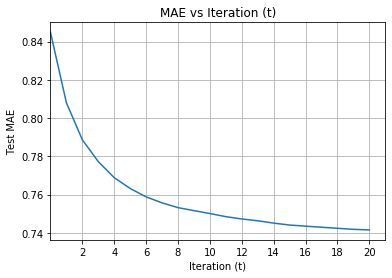

In [5]:
plt.plot(list(range(tmax)), MAE)
plt.xlabel('Iteration (t)')
plt.ylabel('Test MAE')
plt.xticks(np.arange(2, tmax, 2))
plt.xlim(0,tmax)
plt.title("MAE vs Iteration (t)")
plt.grid()

print("Minimum MAE:", "{0:0.2f}".format(min(MAE)))
print("Maximum MAE:", "{0:0.2f}".format(max(MAE)))

In [6]:
reconstruction

array([[4. , 3.5, 4. , ..., 4.5, 3.5, 4. ],
       [4. , 3.5, 4. , ..., 4.5, 3.5, 4. ],
       [4. , 3.5, 4. , ..., 4.5, 3.5, 4. ],
       ...,
       [4. , 3.5, 4. , ..., 4.5, 3.5, 4. ],
       [4. , 3.5, 4. , ..., 4.5, 3.5, 4. ],
       [4. , 3.5, 4. , ..., 4.5, 3.5, 3.5]])

In [51]:
mmmm = []

for i in range(nmovie):
  mmmm.append(MAE(reconstruction[:,i] , movie_means))

plt.hist(np.array(mmmm))

([array([   0.,    2.,    9.,  512., 1363., 1797.,   23.,    0.,    0.,
            0.]),
  array([   0.,    3.,    0.,  109.,  499., 2752.,  343.,    0.,    0.,
            0.]),
  array([   0.,    2.,   16.,  508., 1372., 1786.,   22.,    0.,    0.,
            0.]),
  array([   0.,    3.,   10.,  514., 1380., 1784.,   15.,    0.,    0.,
            0.]),
  array([   0.,    0.,   17.,   63.,  138., 1915., 1531.,   42.,    0.,
            0.]),
  array([   0.,    2.,   17.,  520., 1370., 1772.,   25.,    0.,    0.,
            0.]),
  array([   1.,    9.,   73., 1794., 1487.,  342.,    0.,    0.,    0.,
            0.]),
  array([   0.,    3.,   19.,  521., 1319., 1784.,   60.,    0.,    0.,
            0.]),
  array([   0.,    1.,    1.,   90.,  445., 2838.,  331.,    0.,    0.,
            0.]),
  array([   0.,    4.,   20.,  538., 1261., 1733.,  150.,    0.,    0.,
            0.]),
  array([   0.,   23.,    4.,  192.,  622., 2559.,  306.,    0.,    0.,
            0.]),
  array([ 

Error in callback <function flush_figures at 0x7f7a89979400> (for post_execute):


KeyboardInterrupt: ignored

In [7]:
[nuser, nmovie] = np.shape(reconstruction)

dataset = []
for u in range(nuser//2):
  for m in range(nmovie//2):
    dataset.append([u,m, reconstruction[u,m]]) 

dataset = np.array(dataset)
print(dataset)

[[   0.     0.     4. ]
 [   0.     1.     3.5]
 [   0.     2.     4. ]
 ...
 [3019.  1850.     2.5]
 [3019.  1851.     3.5]
 [3019.  1852.     4. ]]


In [0]:
# Trainng Samples loaded from Github Repo
titles_path = 'https://raw.githubusercontent.com/usef-kh/EC503Project/master/Datasets/ml-1m/movies.dat'
users_path = 'https://raw.githubusercontent.com/usef-kh/EC503Project/master/Datasets/ml-1m/users.dat'

ratings = pd.DataFrame(data=dataset, index=dataset[0:,0],  columns=['UserID', 'MovieID', 'Rating'])
titles = pd.read_csv(titles_path, sep = "::", names = ['MovieID', 'Title', 'Genres'], encoding ='latin-1')
users = pd.read_csv(users_path, sep = "::", names = ['UserID', 'Gender', 'Age', 'Occupation', 'Zip Code'], encoding ='latin-1')

users.dropna(inplace=True)

In [9]:
all_genres = []
for index,row in titles.iterrows():
  #  separate the genres and put into a list
  temp = row.Genres.split('|')
   #  store all the genres into a list
  all_genres =  all_genres + temp
  # unique genres list
genres = list(set(all_genres))
lenGeneres = len(genres)
zeroVec = np.zeros(lenGeneres) 
#  store the genres and corresponding index into a dictionary
genreDict0 = dict(enumerate(genres))
#  store genres as key and index as value
genreDict = {value:key for key, value in genreDict0.items()}
print(genreDict)


{'Thriller': 0, 'Sci-Fi': 1, 'Adventure': 2, 'Comedy': 3, 'Fantasy': 4, 'Drama': 5, 'Animation': 6, 'Mystery': 7, 'Horror': 8, 'Musical': 9, 'Romance': 10, 'Film-Noir': 11, 'Western': 12, 'War': 13, 'Crime': 14, 'Action': 15, 'Documentary': 16, "Children's": 17}


In [10]:
genreArray = np.empty([titles.shape[0],lenGeneres])
oldidx = -1
for index,row in titles.iterrows():
  try:
    # create a zeros list
    genresVec = np.zeros(lenGeneres)
    # get genres
    genreTmp = row.Genres.split('|')

    for gen in genreTmp: 
        # get genres index
      genID = genreDict[gen]
      # assign the corresponding genres index to 1
      genresVec[genID] = 1

    # put the 0 and 1 vector into a whole matrix representing the genres
    genreArray[index] = genresVec

  except:  
    print("found a bad movie")
print(genreArray.shape)
print(genreArray)

(3883, 18)
[[0. 0. 0. ... 0. 0. 1.]
 [0. 0. 1. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


In [11]:
print(len(genreArray),titles.shape)

df2 = pd.DataFrame(genreArray, dtype=int, columns=list(genreDict.keys()))
titles = pd.concat([titles, df2], axis=1)
titles.head()

3883 (3883, 3)


,MovieID,Title,Genres,Thriller,Sci-Fi,Adventure,Comedy,Fantasy,Drama,Animation,Mystery,Horror,Musical,Romance,Film-Noir,Western,War,Crime,Action,Documentary,Children's
0,1,Toy Story (1995),Animation|Children's|Comedy,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1
1,2,Jumanji (1995),Adventure|Children's|Fantasy,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
2,3,Grumpier Old Men (1995),Comedy|Romance,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,4,Waiting to Exhale (1995),Comedy|Drama,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,5,Father of the Bride Part II (1995),Comedy,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [14]:
train_movies = pd.merge(ratings, titles, on='MovieID')
train_movies = train_movies.reindex(np.random.permutation(train_movies.index))
test_movies = pd.merge(test, titles, on='MovieID')

train = pd.merge(train_movies, users, on='UserID')
test = pd.merge(test_movies, users, on='UserID')

print(f"ntotal: {ntrain}\nntest: {ntest}")
train.head()

ntotal: 850177
ntest: 150032


,UserID,MovieID,Rating,Title,Genres,Thriller,Sci-Fi,Adventure,Comedy,Fantasy,Drama,Animation,Mystery,Horror,Musical,Romance,Film-Noir,Western,War,Crime,Action,Documentary,Children's,Gender,Age,Occupation,Zip Code
0,2947.0,770.0,4.0,Costa Brava (1946),Drama,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,F,25,0,02138
1,2947.0,200.0,4.0,"Tie That Binds, The (1995)",Thriller,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,F,25,0,02138
2,2947.0,1198.0,3.5,Raiders of the Lost Ark (1981),Action|Adventure,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,F,25,0,02138
3,2947.0,1316.0,3.5,Anna (1996),Drama,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,F,25,0,02138
4,2947.0,1126.0,3.0,Drop Dead Fred (1991),Comedy|Fantasy,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,F,25,0,02138


In [0]:
train['Male'] = 0 
train['Female'] = 0

train['Male'][train.Gender == 'M'] = 1
train['Female'][train.Gender == 'F'] = 1

test['Male'] = 0 
test['Female'] = 0

test['Male'][test.Gender == 'M'] = 1
test['Female'][test.Gender == 'F'] = 1

In [0]:
#Create train and test data 
from sklearn.metrics import mean_absolute_error as MAE

Features = ['UserID', 'MovieID', 'Age', 'Occupation', 'Male', 'Female'] + list(genreDict.keys())
xtrain = train[Features]
ytrain = train['Rating']

xtest = test[Features]
ytest = test['Rating']

In [20]:
# OLS prediction
from sklearn.linear_model  import LinearRegression
ols = LinearRegression(normalize = True, fit_intercept = True)
ols.fit(xtrain, ytrain)

print("Normal")
pred_train = ols.predict(xtrain)
print("Train MAE:", MAE(pred_train, ytrain))
pred_test = ols.predict(xtest)
print("Test MAE:", MAE(pred_test, ytest))


print("\nRounded")
pred_train = np.round(2*ols.predict(xtrain))/2 
print("Train MAE:", MAE(pred_train, ytrain))
pred_test = np.round(2*ols.predict(xtest))/2 
print("Test MAE:", MAE(pred_test, ytest))

Normal
Train MAE: 0.4096965450191067
Test MAE: 0.9270300314448543

Rounded
Train MAE: 0.4008968052855087
Test MAE: 0.9446184813906366


In [0]:
# Ridge prediction
from sklearn.linear_model import Lasso as Ridge
mae = []
temp= []
for a in range(1, 10):
  ridge = Ridge(alpha = a, normalize = True, fit_intercept = True)
  ridge.fit(xtrain, ytrain) 

  # print("Normal")
  pred_train = ridge.predict(xtrain)
  temp.append(MAE(pred_train, ytrain))
  pred_test = ridge.predict(xtest)
  temp.append(MAE(pred_test, ytest))


  # print("\nRounded")
  pred_train1 = np.round(2*pred_train)/2 
  temp.append(MAE(pred_train1, ytrain))
  pred_test1 = np.round(2*pred_test)/2 
  temp.append(MAE(pred_test1, ytest))
  mae.append(temp)

mae = np.array(mae)

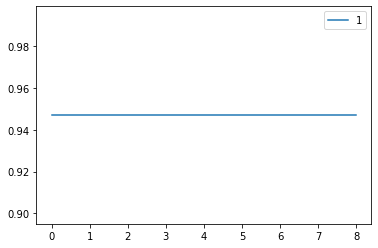

In [39]:
plt.figure(1)
for i in range(3,4):
  plt.plot(mae[:,i])
plt.legend('1234')

In [41]:
# Lasso prediction
from sklearn.linear_model import Lasso
lasso = Lasso(alpha=10, normalize = True, fit_intercept = True)
lasso.fit(xtrain, ytrain)  

print("Normal")
pred_train = lasso.predict(xtrain)
print("Train MAE:", MAE(pred_train, ytrain))
pred_test = lasso.predict(xtest)
print("Train MAE:", MAE(pred_test, ytest))


print("\nRounded")
pred_train = np.round(2*lasso.predict(xtrain))/2 
print("Train MAE:", MAE(pred_train, ytrain))
pred_test = np.round(2*lasso.predict(xtest))/2 
print("Train MAE:", MAE(pred_test, ytest))

Normal
Train MAE: 0.41341500825389677
Train MAE: 0.9225592468476487

Rounded
Train MAE: 0.40294511813818906
Train MAE: 0.9470446304788311
